# Results request - CAZ_R performance on TESSy

In [11]:
import torch
import yaml
import wandb
import argparse
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime
from sklearn.metrics import roc_auc_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader

BASE_DIR = Path(os.path.abspath(''))
sys.path.append(str(BASE_DIR))
os.chdir(BASE_DIR)

# user-defined modules
from multimodal.models import BERT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [12]:
config = yaml.safe_load(open("config_MM.yaml"))
data_config = config['data']
defined_antibiotics = sorted(list(set(data_config['antibiotics']['abbr_to_name'].keys()) - set(data_config['exclude_antibiotics'])))
ab_to_idx = {ab: idx for idx, ab in enumerate(defined_antibiotics)}
specials = config['specials']
cls_token, pad_token, mask_token = specials['CLS'], specials['PAD'], specials['AB_MASK']
max_seq_len = 56

In [13]:
ab_to_idx

{'AMK': 0,
 'AMP': 1,
 'CAZ': 2,
 'CIP': 3,
 'CRO': 4,
 'CTX': 5,
 'ETP': 6,
 'FEP': 7,
 'GEN': 8,
 'IPM': 9,
 'LVX': 10,
 'MEM': 11,
 'MFX': 12,
 'NAL': 13,
 'TOB': 14}

## Load and prepare dataset for inference

In [14]:
ds_path = data_config['TESSy']['load_path']
# ds_path = 'data/TESSy_15_all_pathogens.pkl'
ds_TESSy = pd.read_pickle(ds_path)
ds_NCBI = pd.read_pickle(data_config['NCBI']['load_path'])
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 1].reset_index(drop=True)
print(f"Total number of samples in TESSy: {len(ds_TESSy):,}")

Total number of samples in TESSy: 1,440,857


CAZ_R experiment

In [15]:
antibiotics = ['CAZ', 'CIP', 'AMP', 'GEN'] # original request
ds_CAZ = ds_TESSy.copy()
ds_CAZ['phenotypes'] = ds_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# ds_CAZ = ds_CAZ[ds_CAZ['phenotypes'].apply(lambda x: 'CAZ_R' in x)].reset_index(drop=True)
ds_CAZ = ds_CAZ[ds_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
ds_CAZ.drop(columns=['num_R', 'num_S', 'num_ab'], inplace=True)
ds_CAZ = ds_CAZ.sample(frac=1, random_state=config['random_state']).reset_index(drop=True)
print(f"Number of selected samples in ds_CAZ: {len(ds_CAZ):,}")

Number of selected samples in ds_CAZ: 703,739


CIP_R experiment

In [16]:
antibiotics = ['CIP', 'AMP', 'CAZ', 'CTX', 'CRO', 'ETP', 'FEP']
ds_CIP = ds_TESSy.copy()
ds_CIP['phenotypes'] = ds_CIP['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# ds_CIP = ds_CIP[ds_CIP['phenotypes'].apply(lambda x: 'CIP_R' in x)].reset_index(drop=True)
ds_CIP = ds_CIP[ds_CIP['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
ds_CIP.drop(columns=['num_R', 'num_S', 'num_ab'], inplace=True)
ds_CIP = ds_CIP.sample(frac=1, random_state=config['random_state']).reset_index(drop=True)
print(f"Number of selected samples in ds_CIP: {len(ds_CIP):,}")

Number of selected samples in ds_CIP: 34,276


In [51]:
ds_balanced = ds_TESSy.copy()
ds_balanced['frac_R'] = ds_balanced['num_R'] / (ds_balanced['num_ab'])
ds_balanced['frac_S'] = ds_balanced['num_S'] / (ds_balanced['num_ab'])
ds_balanced = ds_balanced[(ds_balanced['frac_R'] > 0.15) & (ds_balanced['frac_R'] < 0.9)].reset_index(drop=True)
print(f"Number of samples in balanced dataset: {len(ds_balanced):,}")
print(f"S/R ratio: {(ds_balanced['num_S'].sum() / ds_balanced['num_ab'].sum()):.1%}/{(ds_balanced['num_R'].sum() / ds_balanced['num_ab'].sum()):.1%}")

ds_CAZ = ds_balanced[ds_balanced['phenotypes'].apply(lambda x: ('CAZ_R' in x) or ('CAZ_S' in x))].reset_index(drop=True)
CAZ_r = ds_CAZ['phenotypes'].apply(lambda x: 'CAZ_R' in x).sum()
print(f"Number of CAZ samples in the balanced dataset: {len(ds_CAZ):,} ({CAZ_r/len(ds_CAZ):.1%} R)")

ds_CIP = ds_balanced[ds_balanced['phenotypes'].apply(lambda x: ('CIP_R' in x) or ('CIP_S' in x))].reset_index(drop=True)
CIP_r = ds_CIP['phenotypes'].apply(lambda x: 'CIP_R' in x).sum()
print(f"Number of CIP samples in the balanced dataset: {len(ds_CIP):,} ({CIP_r/len(ds_CIP):.1%} R)")

Number of samples in balanced dataset: 402,249
S/R ratio: 62.3%/37.7%
Number of CAZ samples in the balanced dataset: 322,685 (30.7% R)
Number of CIP samples in the balanced dataset: 373,115 (62.1% R)


Prepare dataset

In [196]:
vocab_path = BASE_DIR / config['fine_tuning']['loadpath_vocab']
vocab = torch.load(vocab_path)

class MMInferenceDataset(Dataset):
    
    def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx, patient_info_only=False):
        self.ds = ds.reset_index(drop=True)
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.specials = specials
        self.CLS, self.PAD = specials['CLS'], specials['PAD']
        self.GENE_MASK, self.AB_MASK = specials['GENE_MASK'], specials['AB_MASK']
        self.device = device
        self.ab = defined_antibiotics[selected_ab_idx]
        
        self.phenotypes = self.ds['phenotypes'].tolist()
        self.year_col = self.ds['year'].astype(str).tolist()
        self.country_col = self.ds['country'].tolist()
        self.gender_col = self.ds['gender'].tolist()
        self.age_col = self.ds['age'].astype(int).astype(str).tolist()
        
        self.columns = ['indices_masked', 'token_types', 'attn_mask', 'target_res', 'masked_sequences']
        
    def prepare_dataset(self):
        masked_phenotypes = []
        target_res = []
        for phen_list in self.phenotypes:
            masked_phen_list = []
            for p in phen_list:
                if p.split('_')[0] != self.ab:
                    if patient_info_only:
                        pass
                    else:
                        masked_phen_list.append(p)
                else:
                    if p == self.ab+'_R':
                        target_res.append(1)
                    else:
                        target_res.append(0)
                    masked_phen_list.append(self.AB_MASK)
            masked_phenotypes.append(masked_phen_list)

        masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i], self.gender_col[i], self.age_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
        token_types = [[0]*5 + [2]*(len(masked_sequences[i])-5) for i in range(len(self.ds))]
        ########### without patient info ###########
        # masked_sequences = [[specials['CLS']] + masked_phenotypes[i] for i in range(len(self.ds))]
        # token_types = [[0] + [2]*(len(masked_sequences[i])-1) for i in range(len(self.ds))]
        
        masked_sequences = [seq + [specials['PAD']]*(max_seq_len-len(seq)) for seq in masked_sequences]
        indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        token_types = [tt + [2]*(max_seq_len-len(tt)) for tt in token_types]
        attn_mask = [[False if token == specials['PAD'] else True for token in seq] for seq in masked_sequences]
        
        rows = zip(indices_masked, token_types, attn_mask, target_res, masked_sequences)
        self.df = pd.DataFrame(rows, columns=self.columns)
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
        token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
        masked_sequences = item['masked_sequences']
        target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
        attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
        return input, token_types, attn_mask, target_res, masked_sequences

CAZ_idx = ab_to_idx['CAZ']
CIP_idx = ab_to_idx['CIP']
AMP_idx = ab_to_idx['AMP']
GEN_idx = ab_to_idx['GEN']

ds = ds_CAZ.copy()
num_samples = 40000
ab_idx = CAZ_idx

# ds = ds_CIP.copy()
# num_samples = len(ds_CIP)
# ab_idx = CIP_idx

selected_ab = defined_antibiotics[ab_idx]
print("selected ab:", selected_ab)

patient_info_only = False

ds_inference = MMInferenceDataset(
    ds.iloc[:num_samples],
    vocab,
    defined_antibiotics,
    max_seq_len,
    specials,
    ab_idx,
    patient_info_only=patient_info_only
)
ds_inference.prepare_dataset()
inference_loader = DataLoader(ds_inference, batch_size=512, shuffle=False)

selected ab: CAZ


## Load vocab & fine-tuned model

In [197]:
torch.cuda.empty_cache()
###################################### pre-trained models ###############################
# model_name = '0.5_2known_WL'
# model_path = 'results/MM/AE_request/PT_with_eval_xknown/'+model_name+'/model_state.pt'

# model_name = 'easyCPT'                            # dumb/0.27 for CAZ, /0.4 for CIP
# model_path = 'results/MM/PT_2024_04_09/'+model_name+'/model_state.pt'

# model_path = 'results/MM/PT_0.75_3known_strong_WL/model_state.pt' # dumb/0.69 for CAZ, 0.22/0.66 for CIP

## focal loss
# model_name = 'bce'                              # 0.0/0.24 for CAZ, 0.0/0.40 for CIP
# model_name = 'gamma0.5'                         # 0.01/0.33 for CAZ, 0.0/0.40 for CIP
# model_name = 'gamma1'                           # 0.14/0.30 for CAZ, 0.0/0.40 for CIP
# model_name = 'gamma2'                           # 0.05/0.03 for CAZ, 0.0/0.40 for CIP
# model_name = 'gamma4'                           # 0.2/0.39 for CAZ, 0.50*/0.41 for CIP  *50/50 predictions
# model_path = 'results/MM/PT_2024-04-15_focal/0.75_2known_'+model_name+'/model_state.pt'

## masking strategy experiments
## 80-10-10 (BERT)
# model_name = 'easyRPT'                      # 0.0/0.31 for CAZ, 0./0.40 for CIP
# model_name = 'mediumRPT'                    # 0.0/0.34 for CAZ, 0./0.40 for CIP
# model_name = 'hardRPT'                      # 0./0.30 for CAZ, 0./0.40 for CIP
# model_name = 'easyCPT'                      # 0.03/0.27 for CAZ, 0./0.40 for CIP
# model_name = 'mediumCPT'                    # 0.0/0.34 for CAZ, 0./0.40 for CIP
# model_name = 'hardCPT'                      # 0.0/0.02 for CAZ, 0./0.37 for CIP
# model_path = 'results/MM/PT_2024-04-15_mask_exp/PT_'+model_name+'_BERT/model_state.pt'
## MASK -> always replace with mask token
# model_name = 'easyRPT'                      # 0.0/0.32 for CAZ, 0./0.41 for CIP
# model_name = 'mediumRPT'                    # 0.0/0.26 for CAZ, 0./0.40 for CIP
# model_name = 'hardRPT'                      # 0.0/0.20 for CAZ, 0./0.41 for CIP
# model_name = 'easyCPT'                      # 0.0/0.0 for CAZ, 0./0.42 for CIP
# model_name = 'mediumCPT'                    # 0.0/0.33 for CAZ, 0./0.41 for CIP
# model_name = 'hardCPT'                      # 0.0/0.0 for CAZ, 0./0.02 for CIP
# model_path = 'results/MM/PT_2024-04-15_mask_exp/PT_'+model_name+'_MASK/model_state.pt'
############################## pre-trained + fine-tuned models #################################
# model_name = 'FT_3known_WL'                     # 0.21/0.57 for CAZ, dumb/0.42 for CIP (PT was 0.5_2known_WL)
# model_name = 'FT_3known_strong_WL'              # 0.43/0.68 for CAZ, 0.25/0.50 for CIP (PT was 0.5_2known_WL) - BEST?
# model_name = 'FT_0.2_strong_WL'                 # 0.66/0.77 for CAZ, 0.89/0.75 for CIP (PT was 0.5_2known_WL)
# model_name = 'FT_class_WL'                      # 0.04/0.53 for CAZ, 0.74/0.61 for CIP (PT was 0.5_2known_WL)
# model_name = 'FT_class_strong_WL'               # dumb/0.76 for CAZ, (0.90)/(0.82) for CIP (PT was 0.5_2known_WL)
# model_name = 'FT_0known_WL'                     # 0.8/0.76 for CAZ, (0.86)/0.56 for CIP (PT was 0.5_2known_WL)

# model_name = 'FT_easyCPT_3known'                # 0.67/0.87 for CAZ, dumb/0.38 for CIP (PT was easyCPT)
# model_name = 'FT_easyCPT_3known_WL'             # 0.85/0.90 for CAZ, 0.09/0.42 for CIP (PT was easyCPT)
# model_name = 'FT_easyCPT_3known_strong_WL'      # (0.89)/0.63 for CAZ, 0.53/0.45 for CIP (PT was easyCPT)

# model_name = 'FT_3knownPT_3known'               # dumb/0.44 for CAZ, dumb/0.18 for CIP (PT was 0.75_3known_strong_WL)
# model_name = 'FT_3knownPT_3known_WL'            # (0.02)/0.45 for CAZ, 0.0/0.54 for CIP (PT was 0.75_3known_strong_WL)
# model_name = 'FT_3knownPT_3known_strong_WL'     # 0.0/0. for CAZ, 0./0. for CIP (PT was 0.75_3known_strong_WL)
# model_name = 'FT_3knownPT_class_WL'             # 0.03/0.37 for CAZ, (0.91)/0.66 for CIP (PT was 0.75_3known_strong_WL)

# model_name = 'FT_2mask_3known_WL'               # 0.02/0.25 for CAZ, 0.0/0.35 for CIP (PT was 2_mask/0.75_3known_WL)
# model_name = 'FT_2mask_3known_lr1e-5_WL'        # 0.01/0.38 for CAZ, 0.0/0.40 for CIP (PT was 2_mask/0.75_3known_WL)
# model_name = 'FT_2mask_3known_strong_WL'        # 0.05/0.29 for CAZ, 0.03/0.40 for CIP (PT was 2_mask/0.75_3known_WL)
# model_path = 'results/MM/AE_request/'+model_name+'/model_state.pt'
############################# pre-trained and fine-tuned on TESSy ##################################
# model_name = ''
# model_path = 'results/MM/'+model_name+'/model_state.pt'
########################### pre-trained models with 2-mask strategy ##################################
# model_name ='PT_0.75_0.2_WL'
# model_name ='PT_0.75_0.8_WL'
# model_path = 'results/MM/2_mask/'+model_name+'/model_state.pt'

####################### pre-trained and fine-tuned normally [FIXED CODE] ############################
# model_name = 'easyRPT'                              # 0.0/0.22 for CAZ, 0.0/0. for CIP
# model_name = 'mediumRPT'                            # 0.0/0.15 for CAZ, 0.0/0. for CIP
# model_name = 'hardRPT'                              # 0.0/0.44 for CAZ, 0.0/0. for CIP
# model_name = 'easyCPT'                              # 0.33/0.1 for CAZ, 0.0/0. for CIP
# model_name = 'mediumCPT'                            # 0.0/0.46 for CAZ, 0.36/0. for CIP
# model_name = 'hardCPT'                              # 0.06/0.30 for CAZ, 0.11/0. for CIP
# model_path = 'results/MM/2024-04-24_class_uniform/FT_'+model_name+'_0_1class/best_model_state.pt'

model_name = 'hardCPT'                              # 0.0/0. for CAZ, 0.0/0. for CIP
# model_path = f'results/MM/AE_request/FT_{model_name}_1_1class/best_model_state.pt'
# model_path = f'results/MM/AE_request/FT_{model_name}_0.75_3known_strong_WL/best_model_state.pt'
model_path = f'results/MM/AE_request/FT_{model_name}_1_2class/best_model_state.pt'

vocab_size = len(vocab)
print("vocab size", vocab_size)
num_ab = 15 # from fine-tuning

bert = BERT(
    config,
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    num_ab=num_ab,
    pad_idx=vocab[pad_token],
    pheno_only=True
).to(device)
print("selected ab", selected_ab)
bert.load_state_dict(torch.load(model_path))

vocab size 1586
selected ab CAZ


<All keys matched successfully>

In [198]:
# print("Model:", model_name)
# results = pd.read_pickle('results/MM/PT_with_eval_xknown/0.5_2known_WL/pt_results.pkl')
# results = pd.read_pickle('results/MM/2_mask/'+model_name+'/pt_results.pkl')
# results = pd.read_pickle('results/MM/PT_2024-04-15_focal/0.75_2known_'+model_name+'/pt_results.pkl')
# results = pd.read_pickle('results/MM/PT_2024-04-15_mask_exp/PT_'+model_name+'_BERT/pt_results.pkl')
# results = pd.read_pickle('results/MM/PT_2024-04-15_mask_exp/PT_'+model_name+'_MASK/pt_results.pkl')
# print(results.keys())
# results['val_ab_stats'].set_index('antibiotic').loc[selected_ab]

In [199]:
print("Model:", model_name)
# results = pd.read_pickle('results/MM/AE_request/'+model_name+'/CV_results.pkl')
# results = pd.read_pickle('results/MM/2024-04-24_class_uniform/FT_'+model_name+'_0_1class/CV_results.pkl')
# results = pd.read_pickle(f'results/MM/AE_request/FT_{model_name}_1_1class/CV_results.pkl')
# results = pd.read_pickle(f'results/MM/AE_request/FT_{model_name}_0.75_3known_strong_WL/CV_results.pkl')
results = pd.read_pickle(f'results/MM/AE_request/FT_{model_name}_1_2class/CV_results.pkl')
print("selected ab:", selected_ab)
results['ab_stats'][0].set_index('antibiotic').loc[selected_ab]

Model: hardCPT
selected ab: CAZ


num_masked_tot                                                  396
num_masked_S                                                    285
num_masked_R                                                    111
num_pred_S                                                      270
num_pred_R                                                      126
num_correct                                                     351
num_correct_S                                                   255
num_correct_R                                                    96
accuracy                                                   0.886364
sensitivity                                                0.864865
specificity                                                0.894737
precision                                                  0.761905
F1                                                         0.810127
auc_score                                                  0.951146
roc_fpr           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [200]:
# ds_NCBI_CAZ = ds_MM.copy()
# ds_NCBI_CAZ.fillna(pad_token, inplace=True)
# ds_NCBI_CAZ['phenotypes'] = ds_NCBI_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# # ds_NCBI_CAZ = ds_NCBI_CAZ[ds_NCBI_CAZ['phenotypes'].apply(lambda x: 'CAZ_R' in x)].reset_index(drop=True)
# ds_NCBI_CAZ = ds_NCBI_CAZ[ds_NCBI_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
# ds_NCBI_CAZ.head()
# print(f"Number of selected samples: {len(ds_NCBI_CAZ):,}")

In [201]:
# vocab = torch.load(BASE_DIR / config['fine_tuning']['loadpath_vocab'])

# class MMInferenceDataset_NCBI(Dataset):
    
#     def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx):
#         self.ds = ds
#         self.vocab = vocab
#         self.max_seq_len = max_seq_len
#         self.specials = specials
#         self.CLS, self.PAD, self.MASK = specials['CLS'], specials['PAD'], specials['MASK']
#         self.device = device
#         self.ab = defined_antibiotics[selected_ab_idx]
        
#         self.phenotypes = self.ds['phenotypes'].tolist()
#         self.year_col = self.ds['year'].astype(str).tolist()
#         self.country_col = self.ds['country'].tolist()
        
#         self.columns = ['indices_masked', 'token_types', 'attn_mask', 'target_res', 'masked_sequences']
        
#     def prepare_dataset(self):
#         masked_phenotypes = []
#         target_caz_res = []
#         for phen_list in self.phenotypes:
#             masked_phen_list = []
#             for p in phen_list:
#                 if p.split('_')[0] != self.ab:
#                     masked_phen_list.append(p)
#                     # pass
#                 else:
#                     if p == self.ab+'_R':
#                         target_caz_res.append(1)
#                     else:
#                         target_caz_res.append(0)
#                     masked_phen_list.append(specials['MASK'])
#             masked_phenotypes.append(masked_phen_list)

#         masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
#         token_types = [[0]*5 + [2]*(len(masked_sequences[i])-5) for i in range(len(self.ds))]
#         masked_sequences = [seq + [pad_token]*(max_seq_len-len(seq)) for seq in masked_sequences]
#         indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
#         token_types = [tt + [2]*(max_seq_len-len(tt)) for tt in token_types]
#         attn_mask = [[False if token == pad_token else True for token in seq] for seq in masked_sequences]
        
#         rows = zip(indices_masked, token_types, attn_mask, target_caz_res, masked_sequences)
#         self.df = pd.DataFrame(rows, columns=self.columns)
    
#     def __len__(self):
#         return len(self.ds)
    
#     def __getitem__(self, idx):
#         item = self.df.iloc[idx]
        
#         input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
#         token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
#         masked_sequences = item['masked_sequences']
#         target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
#         attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
#         return input, token_types, attn_mask, target_res

# CAZ_idx = ab_to_idx['CAZ']
# CIP_idx = ab_to_idx['CIP']
# AMP_idx = ab_to_idx['AMP']
# GEN_idx = ab_to_idx['GEN']
# CTX_idx = ab_to_idx['CTX']
# ab_idx = CAZ_idx
# selected_ab = defined_antibiotics[ab_idx]
# print("ab idx (ab):", ab_idx, selected_ab)

# num_samples_NCBI = len(ds_NCBI_CAZ)
# ds_inference_NCBI = MMInferenceDataset_NCBI(ds_NCBI_CAZ, vocab, defined_antibiotics, max_seq_len, specials, ab_idx)
# inference_loader_NCBI = DataLoader(ds_inference_NCBI, batch_size=512, shuffle=False)

## Main process

In [202]:
with torch.no_grad():
    bert.eval()
    # ds = ds_inference_NCBI
    # loader = inference_loader_NCBI  
    ds = ds_inference
    loader = inference_loader
    ds.prepare_dataset()
    print("selected ab:", selected_ab)
    print("Number of samples in inference dataset:", len(ds))
    print("Number of batches in inference loader:", len(loader))
    print("="*50)
    tot_num_S, tot_num_R = 0, 0
    tot_correct, tot_num_correct_S, tot_num_correct_R = 0, 0, 0
    tot_num_pred_S, tot_num_pred_R = 0, 0
    pred_sigmoids = torch.tensor([]).to(device)
    targets = torch.tensor([]).to(device)
    for input, token_types, attn_mask, target_res, masked_sequences in loader:
        pred_logits = bert(input, token_types, attn_mask)
        pred_res = torch.where(pred_logits > 0, torch.ones_like(pred_logits), torch.zeros_like(pred_logits))
        pred_sigmoids = torch.cat((pred_sigmoids, torch.sigmoid(pred_logits[:, ab_idx])))
        targets = torch.cat((targets, target_res))
        ab_preds = pred_res[:, ab_idx]
        num_R_pred = ab_preds.sum().item()
        tot_num_pred_R += num_R_pred
        num_S_pred = ab_preds.shape[0] - num_R_pred
        tot_num_pred_S += num_S_pred 
            
        num_S = target_res.eq(0).sum().item()
        tot_num_S += num_S
        num_R = target_res.eq(1).sum().item()
        tot_num_R += num_R
        
        eq = torch.eq(pred_res[:, ab_idx], target_res)
        num_correct = eq.sum().item()
        tot_correct += num_correct
        num_correct_R = eq[target_res == 1].sum().item()
        tot_num_correct_R += num_correct_R
        num_correct_S = eq[target_res == 0].sum().item()
        tot_num_correct_S += num_correct_S
        num_R_pred = pred_res[:, ab_idx].sum().item()
    print(f"Total {selected_ab} accuracy: {tot_correct/(tot_num_S+tot_num_R):.4f}")
    print(f"Data imbalance (R_share) of {selected_ab}: {tot_num_R/(tot_num_S+tot_num_R):.4f}")
    print(f"Share of predictions that were {selected_ab}_R: {tot_num_pred_R/(tot_num_S+tot_num_R):.4f}")
    print(f"Share of predictions that were {selected_ab}_S: {tot_num_pred_S/(tot_num_S+tot_num_R):.4f}")
    print(f"Total {selected_ab}_R accuracy: {tot_num_correct_R/tot_num_R:.4f}")
    if tot_num_pred_R > 0:
        print(f"Precision: {tot_num_correct_R/tot_num_pred_R:.4f}")
    print(f"Total {selected_ab}_S accuracy: {tot_num_correct_S/tot_num_S:.4f}")

selected ab: CAZ
Number of samples in inference dataset: 40000
Number of batches in inference loader: 79
Total CAZ accuracy: 0.9101
Data imbalance (R_share) of CAZ: 0.0899
Share of predictions that were CAZ_R: 0.0000
Share of predictions that were CAZ_S: 1.0000
Total CAZ_R accuracy: 0.0000
Total CAZ_S accuracy: 1.0000


In [203]:
fpr, tpr, thresholds = roc_curve(targets.cpu().numpy(), pred_sigmoids.cpu().numpy())
auc_score = auc(fpr, tpr)
print(f"AUC: {auc_score:.4f}")
best_index = np.argmax(tpr-fpr)
best_threshold = thresholds[best_index]
fpr_best, tpr_best = fpr[best_index], tpr[best_index]
fdr= fpr_best/(fpr_best+tpr_best)
print(f"Best threshold: {best_threshold:.4f}")
print(f"At best, TPR: {tpr[best_index]:.4f}, with FPR: {fpr[best_index]:.4f} and FDR: {fdr:.4f}")

AUC: 0.7967
Best threshold: 0.0612
At best, TPR: 0.9633, with FPR: 0.4491 and FDR: 0.3179


ROC Curve

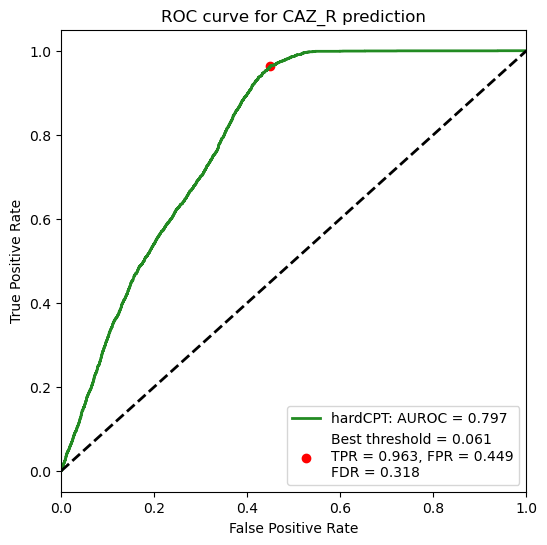

In [204]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='forestgreen', lw=2, label=f'{model_name}: AUROC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
label = f'Best threshold = {best_threshold:.3f}\nTPR = {tpr_best:.3f}, FPR = {fpr_best:.3f}\nFDR = {fdr:.3f}'
plt.scatter(fpr_best, tpr_best, color='red', label=label)
plt.xlim([0.0, 1.0])
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve for {selected_ab}_R prediction')
plt.show()

Histogram over sigmoid values

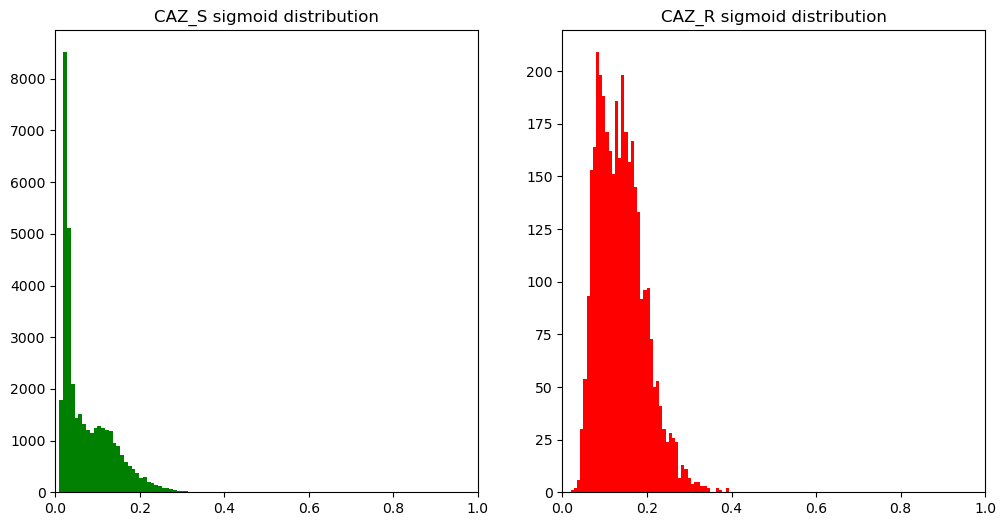

In [205]:
pred_sigmoids_np = pred_sigmoids.cpu().numpy()
targets_np = targets.cpu().numpy()
pred_sigmoids_R = pred_sigmoids_np[targets_np == 1]
pred_sigmoids_S = pred_sigmoids_np[targets_np == 0]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(pred_sigmoids_S, bins=50, color='green', label=f'{selected_ab}_S')
axes[0].set_title(f'{selected_ab}_S sigmoid distribution')
axes[0].set_xlim(0, 1)
axes[1].hist(pred_sigmoids_R, bins=50, color='red', label=f'{selected_ab}_R')
axes[1].set_title(f'{selected_ab}_R sigmoid distribution')
axes[1].set_xlim(0, 1)
plt.show()